In [1]:
from torch.nn import Module, Sequential, Linear, LeakyReLU, Sigmoid, BCELoss
from torch.utils.data import DataLoader, TensorDataset
from torch import device, cuda
from torch.optim import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay
import numpy as np 
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from time import time
import os

import sys
sys.path.append('..')  
from src.utils.RawDataReader import RawDataReader



In [2]:
reader = RawDataReader()
labels = reader.get_labels()
datasets, means, stds = reader.get_normalised_dataset()

In [3]:
num_labels = labels.shape[1]

validation_split = 0.20
test_split = 0.20
batch_size = 2048 * 4
learning_rate = 0.001
epochs = 99
hidden_layers = 10

num_folds = 10

random_state = 1

device = device("cuda" if cuda.is_available() else "cpu")
print(f"Training on {device}")

Training on cuda


In [4]:
class SingleHeadModel(Module):
    def __init__(self, feature_count:int, hidden_count:int=5):
        super(SingleHeadModel, self).__init__()

        self.slope = 0.001

        self.model = Sequential(
            *[self.linear_block(feature_count,feature_count) for _ in range(hidden_count)],
            Linear(in_features=feature_count, out_features=1),
            Sigmoid()
        )

    def linear_block(self, in_features, out_features):
        return Sequential(
            Linear(in_features=in_features, out_features=out_features),
            LeakyReLU(negative_slope=self.slope)
        )
    
    def forward(self, x):
        return self.model(x)


In [5]:
class FusedHeadModel(Module):
    def __init__(self, feature_count:int, hidden_count:int=10, r=None, timestamp=None):
        super(FusedHeadModel, self).__init__()

        self.feature_count = feature_count
        self.timestamp = timestamp
        self.hidden_count = hidden_count
        self.r = r
        self.heads = []

        for _ in range(num_labels):
            self.heads.append(SingleHeadModel(feature_count=self.feature_count))

    def get_singel_head_model_path(self, label):
        return f"../models/{self.timestamp}/SingleHeadModel_norm_{self.hidden_count}hidden_r{self.r}_label{label}.pth"
    
    def get_singel_head_model(self, label):
        path = self.get_singel_head_model_path(label)
        model = SingleHeadModel(
            feature_count=self.feature_count,
            hidden_count=hidden_layers
        ).to(device)
        model.load_state_dict(torch.load(path))

        return model
    
    def forward(self, x):
        output = []
        for _ in range(num_labels):
            pred = self.heads[_](x)
            output.append(pred)
        return torch.cat(output, dim=1)

fused_model = FusedHeadModel(feature_count=datasets[1].shape[1])
fused_model(torch.rand(1,datasets[1].shape[1]))

tensor([[0.4943, 0.4905, 0.4991, 0.5098, 0.4970, 0.5023, 0.4875, 0.4984, 0.4929,
         0.4944, 0.5041, 0.5029, 0.4974, 0.5007, 0.4942, 0.5025, 0.4907, 0.5082,
         0.5089]], grad_fn=<CatBackward0>)

In [6]:
# curr_time = time()
# os.mkdir(f"../models/{curr_time}")

# torch.save(fused_model.state_dict(), f"../models/{curr_time}/R{r}_model.pth")

In [7]:
# curr_time = '1701454903.1140416'
# prediction_array = []

# steps = 50

# for label in range(19):
#     model = SingleHeadModel(
#         feature_count=feature_count,
#         hidden_count=hidden_layers
#     ).to(device)
#     model.load_state_dict(torch.load(f'../models/{curr_time}/SingleHeadModel_norm_{hidden_layers}hidden_r{r}_label{label}.pth'))
    
#     model.eval()
#     predictions = (model(curr_dataset.to(device)) > 0.5).float()
#     prediction_array.append(predictions)
#     # predictions.sum()
#     # # labels[:,[label]].sum()

#     predictions = predictions.to("cpu")
#     c_labels = labels[:,[label]]
#     tp = []
#     tn = []
#     fp = []
#     fn = []
#     thresholds = np.array(range(steps))/steps

#     for theta in thresholds:
#         tn_, fp_, fn_, tp_ = confusion_matrix(c_labels, (predictions > theta).float()).ravel()
#         tn.append(tn_)
#         fp.append(fp_)
#         fn.append(fn_)
#         tp.append(tp_)
 
#     plt.plot(thresholds, tn, label='TN')
#     plt.plot(thresholds, fn, label='FN')
#     plt.plot(thresholds, tp, label='TP')
#     plt.plot(thresholds, fp, label='FP')
#     plt.xlabel('Threshold')
#     plt.ylabel('Count')
#     plt.title(f'Distribution for label {label}')
#     plt.legend()
#     plt.show()


In [8]:
time_stamps = {
    1: "1701700289.3819304",
    2: "1701700530.5930192",
    3: "1701700548.138917"
}

f1s = {}
f1_validations = {}

for r in reader.rs:

    curr_dataset = datasets[r]
    feature_count = curr_dataset.shape[1]

    fused_model = FusedHeadModel(feature_count=feature_count)

    f1s[r] = []
    f1_validations[r] = []

    for label_index in range(num_labels):
        curr_label = labels[:,[label_index]]
        x, x_val, y, y_val = train_test_split(curr_dataset, curr_label, test_size=validation_split, random_state=random_state)
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        
        train_dataset = TensorDataset(x,y)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        head_model = SingleHeadModel(feature_count=feature_count, hidden_count=10)
        head_model.to(device)
        criterion = BCELoss().to(device)
        optimizer = Adam(head_model.parameters(), lr=learning_rate)

        for epoch in tqdm(range(epochs), ascii=False, desc=f"R{r}, Label:{label_index} Epoch"):
            head_model.train()
            total_loss = 0
            for batch_features, batch_labels in train_loader:
                optimizer.zero_grad()
                predictions = head_model(batch_features.to(device))
                loss = criterion(predictions, batch_labels.to(device))
                loss.backward()
                optimizer.step()
                total_loss += loss
                total_loss = total_loss / len(train_loader)

        fused_model.heads[label_index] = head_model

    k_fold = KFold(n_splits=num_folds*5, shuffle=True, random_state=random_state)


    for fold_index, (_train_index, test_index) in enumerate(k_fold.split(labels)):
        test_x = curr_dataset[test_index]
        test_y = labels[test_index]

        fused_model.eval()
        test_y_pred = (fused_model(test_x.to(device))>0.5).float()
        f1 = f1_score(test_y,test_y_pred.cpu(), average="micro")
        f1s[r].append(f1)       
        val_y_pred = (fused_model(x_val.to(device))>0.5).float()
        f1 = f1_score(y_val.cpu(),val_y_pred.cpu(), average="micro")
        f1_validations[r].append(f1)

        
    # for label_index in range(num_labels):
    #     torch.save(fused_model.heads[label_index].state_dict(), f"../models/{time_stamps[1]}/R{r}_label{label_index}_model.pth")
        
    # break


R1, Label:18 Epoch: 100%|██████████| 99/99 [00:15<00:00,  6.37it/s]


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

In [10]:
y_val

tensor([[0.],
        [1.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]], device='cuda:0')

In [9]:
f1_score(y_val.cpu(),val_y_pred.cpu(), average="micro")

ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

<Axes: title={'center': 'F1 Score for 10 Layer Fused Model '}, xlabel='F1 Score', ylabel='Frequency'>

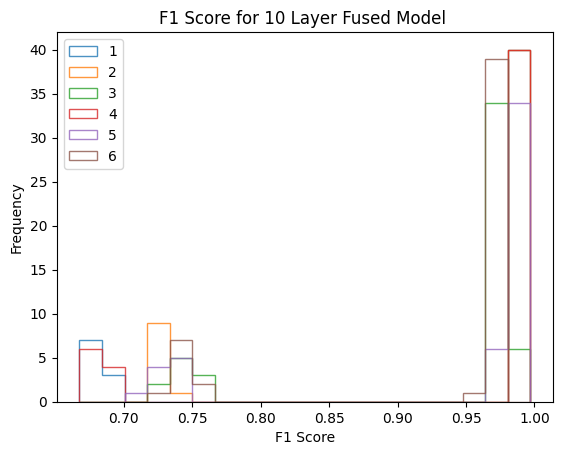

In [ ]:
f1_scores_df = pd.DataFrame(f1s)

f1_scores_df.plot.hist(alpha=0.8, bins=20, histtype=u'step',xlabel="F1 Score", title="F1 Score for 10 Layer Fused Model ")

<Axes: title={'center': 'Mean F1 Score for 10 Layer Fused Model'}, xlabel='Datasets', ylabel='F1 Score'>

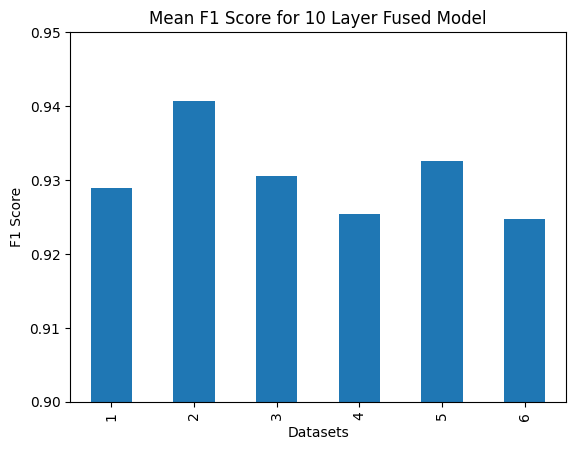

In [ ]:
f1_scores_df.mean().plot.bar(ylim=(0.9,0.95), xlabel="Datasets", ylabel="F1 Score", title="Mean F1 Score for 10 Layer Fused Model")

<Axes: title={'center': 'STD F1 Score for 10 Layer Fused Model'}, xlabel='Datasets', ylabel='F1 Score'>

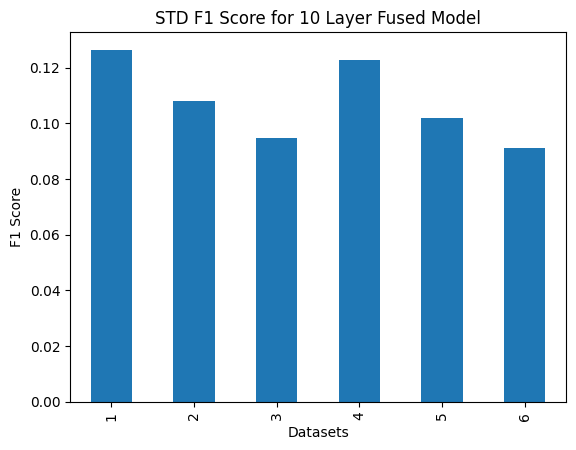

In [ ]:
f1_scores_df.std().plot.bar( xlabel="Datasets", ylabel="F1 Score", title="STD F1 Score for 10 Layer Fused Model")

In [ ]:
f1_scores_df.to_csv("../data/recordes/f1_measured.csv")

In [ ]:
# fused_model.eval()
# l = (fused_model(curr_dataset[:600].to())>0.5).float()
# f1 = f1_score(labels[:600],l.cpu(), average="micro")
# print(f1)

# torch.save(fused_model.state_dict(), f"../models/{time_stamps[1]}/R{r}_model.pth")

# fused_model = FusedHeadModel(feature_count=curr_dataset.shape[1])
# for label in range(num_labels):
#     fused_model.heads[label].load_state_dict(torch.load(f"../models/{time_stamps[1]}/R{r}_label{label_index}_model.pth"))
# fused_model.eval()
# l = (fused_model(curr_dataset[:600])>0.5).float()
# f1 = f1_score(labels[:600],l.cpu(), average="micro")
# print(f1)

In [ ]:
# fused_model_t = FusedHeadModel(feature_count=curr_dataset.shape[1])
# l = (fused_model_t(curr_dataset[:600])>0.5).float()
# f1_score(labels[:600],l.cpu(), average="micro")